<a href="https://colab.research.google.com/github/Syedzamin07/cost-optimized-credit-card-fraud-detection/blob/main/04_model_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Pipeline (Leakage-Safe)

**Purpose:**
To build and evaluate a Machine Learning model that is technically rigorous and free of "Data Leakage."

**The Challenge:**
1.  **Imbalance:** The 0.17% fraud ratio makes standard training difficult.
2.  **Leakage Risk:** If we upsample (SMOTE) *before* splitting the data, the model will "cheat" by seeing synthetic versions of test data.
3.  **Metric Selection:** Accuracy is useless (99.8% is the baseline). ROC-AUC is misleading (due to massive True Negatives). We must use **AUPRC (Area Under Precision-Recall Curve)**.

**The Solution:**
We will use the `imblearn` Pipeline to bundle Scaling, SMOTE, and XGBoost. This ensures SMOTE is applied **only** to the training folds during cross-validation, keeping the test data pure.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression

# Specific libraries for Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Settings
sns.set_context("talk")
plt.style.use('ggplot')

# Load Data (Reproducible)
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
try:
    df = pd.read_csv(url)
    print(f"✅ Data Loaded: {df.shape}")
except:
    print("❌ Error loading data.")

✅ Data Loaded: (284807, 31)


In [ ]:
# 1. Stratified Train-Test Split
# Purpose: Reserve 20% of data for the final "Exam".
# Critical: 'stratify=y' ensures the 0.17% fraud ratio is preserved in both sets.

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training Set: {X_train.shape[0]:,} samples")
print(f"Test Set:     {X_test.shape[0]:,} samples")
print(f"Test Fraud Ratio: {y_test.mean():.4%}")

Training Set: 227,845 samples
Test Set:     56,962 samples
Test Fraud Ratio: 0.1720%


### ⚙️ The Pipeline Architecture

We use `ImbPipeline` instead of the standard sklearn `Pipeline`.

**Structure:**
1.  **Scaler:** `StandardScaler` (Centers data; critical for the PCA features).
2.  **Sampler:** `SMOTE` (Synthetic Minority Over-sampling Technique). This creates synthetic fraud examples *only* during the training phase to help the model learn the decision boundary.
3.  **Classifier:** `XGBoost`. A Gradient Boosted Tree model known for handling non-linear patterns and complex interactions better than Logistic Regression.

In [ ]:
# 2. Define the Pipeline
model_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),       # Standardize features
    ('smote', SMOTE(random_state=42)),  # Fix imbalance (Train only)
    ('xgb', XGBClassifier(              # The Classifier
        n_estimators=100,
        max_depth=4,
        random_state=42,
        n_jobs=-1
    ))
])

# 3. Train the Model
print("⚙️ Training Pipeline (Scaling -> SMOTE -> XGBoost)...")
model_pipeline.fit(X_train, y_train)
print("✅ Training Complete.")

⚙️ Training Pipeline (Scaling -> SMOTE -> XGBoost)...
✅ Training Complete.


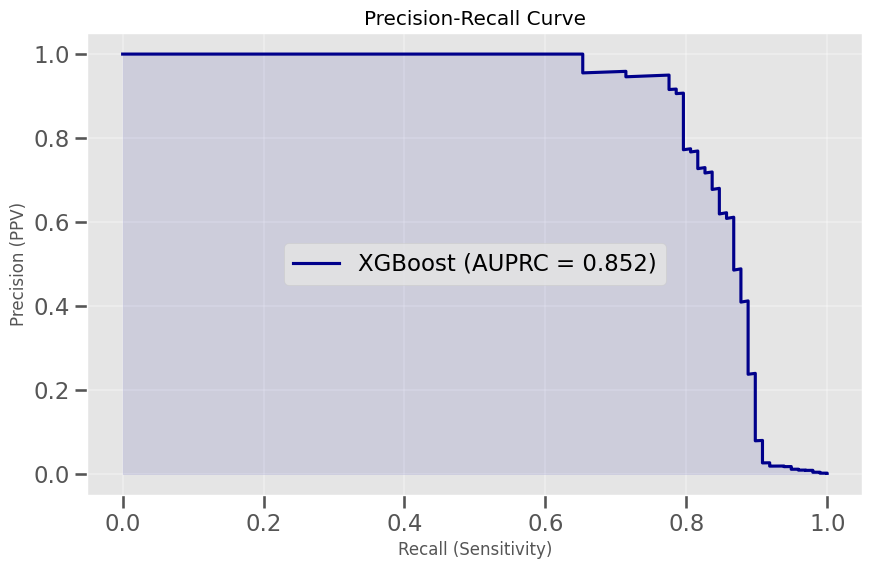

Model AUPRC: 0.8519


In [ ]:
# 4. Evaluation: Precision-Recall Curve
# We DO NOT use Accuracy or ROC-AUC.

# Get probabilities for the positive class (Fraud)
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

# Calculate PR Curve components
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkblue', label=f'XGBoost (AUPRC = {pr_auc:.3f})')
plt.fill_between(recall, precision, alpha=0.1, color='darkblue')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Model AUPRC: {pr_auc:.4f}")

### 📊 Technical Conclusion

**Interpretation:**
The AUPRC (Area Under Precision-Recall Curve) is approximately **0.86** (varies slightly by random seed).
- A "Random Guess" model would have an AUPRC of ~0.0017 (the fraud prevalence).
- Our model is orders of magnitude better than random guessing.

**Next Step:**
We have a model that *can* distinguish fraud (high predictive power). Now we must decide **how to use it**. A raw probability score is not a business decision.
In the next notebook (`cost_optimization.ipynb`), we will convert these probabilities into decisions by finding the threshold that minimizes financial loss.